## <font color="orange">Gaussian Naive Bayes for MNIST Digits Classification</font>

### Imports

In [1]:
import math #to check for nan
import numpy as np
from numpy import mean, std #mean and standard deviation for gaussian probabilities
from scipy.stats import norm #gaussian probabilities
from math import log # to calculate posterior probability
import tensorflow as tf
import matplotlib.pyplot as plt #display images of digits

### Data

#### Load mnist data from Tensorflow Keras library

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#### Sanity check for data getting loaded

In [3]:
print([i.shape for i in (x_train, y_train, x_test, y_test)])
print([type(i) for i in (x_train, y_train, x_test, y_test)])
print('classes, num_classes: ', np.unique(y_train), len(np.unique(y_train)))

[(60000, 28, 28), (60000,), (10000, 28, 28), (10000,)]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
classes, num_classes:  [0 1 2 3 4 5 6 7 8 9] 10


### Model

#### Training Algorithm

In [4]:
'''
    return
            classes: (list) of unique class names in the dataset,
             got from the last column named class_colname.
             
            features: (list) of features (column names) in the dataset.
             this excludes the last column which we expect it to have the class labels.
             
            prior: (1-d array) of dim num_classes
            (prior probability of a set of features belonging to a class)
            
            mean_std: (3-d array) of dim num_classes x num_features x 2 (2: mean and std)
            (mean and standard deviation for all features, given the class)
            
    arguments:
    df: (dataframe) with features and class names (should have a 'class' column in addition to the feature columns).
    class_colname: (string) provide suitable column name otherwise, using the class_colname argument.
'''
def train_gaussian_nb(X, y):
    #number of classes
    classes = np.unique(y)
    num_classes = len(classes)
    #number of data points and features
    N, dim_x, dim_y = X.shape[0], X.shape[1], X.shape[2]
    
    #data structures for priors and
    # (mean, standard deviation) pairs for each feature and class
    # to later calculate likelihood (conditional probability of feature given class)
    prior = np.zeros(num_classes, dtype=float)
    X_mean = np.empty((num_classes, dim_x, dim_y), dtype=float)
    X_std = np.empty((num_classes, dim_x, dim_y), dtype=float)
    
    #for each class...
    for cls in range(num_classes):
        #use a boolean index list to extract images of this class
        bool_idx_list = [True if c==cls else False for c in y]
        X_cls = X[bool_idx_list]
        
        #calculate prior probability of data point belonging to class cls
        prior[cls] = len(X_cls) / N

        #for each dim_x by dim_y, calculate mean and std, across all data points of this class
        X_mean[cls] = mean(X_cls, axis=0)
        X_std[cls] = std(X_cls, axis=0)
            
    return classes, dim_x, dim_y, prior, X_mean, X_std

#### Prediction Algorithm

##### original straightforward approach

In [5]:
'''
    return (integer) the (0-based) index of class to which the document belongs
    
    arguments:
    num_classes: (int) number of classes
    num_features: (int) number of features
    prior: (1-d array) of dim num_classes
           (prior probability of a set of features belonging to a class)
    mean_std: (3-d array) of dim num_classes x num_features x 2 (2: mean and std)
              (mean and standard deviation for all features, given the class)
    x: (list) of features
'''
def apply_gaussian_naive_bayes(num_classes, dim_x, dim_y, prior, X_mean, X_std, x):
    score = np.zeros((num_classes), dtype=float)
    
    #for each class...
    for cls in range(num_classes):
        
        #for this class, add the log-prior probability to the score
        score[cls] += log(prior[cls], 10) #log to the base 10
        
        #for each feature, add the log-likelihood to the score
        for i_x in range(dim_x):
            for i_y in range(dim_y):
                #calculate likelihood from the trained mean and standard deviation
                mu = X_mean[cls][i_x][i_y]
                sigma = X_std[cls][i_x][i_y]
                likelihood = norm(mu, sigma).pdf(x[i_x][i_y])
                #print(mu, sigma, x[i_x][i_y], likelihood)

                #add the log-likelihood to the score
                
                #ValueError exception raised if likelihood is 0 and we take a log.
                #To avoid this, we skip adding log_likelihood to the score.
                #We may argue that score should be penalized for
                # such a great mismatch of pixel intensity for a class,
                # but, these pixels are more of a candidate of noise, and can be ignored.
                #Also, skip NaN values for likelihood (when mu and sigma are 0 and so is x)
                if (math.isnan(likelihood) == True or likelihood == 0):
                    continue
                
                #print(likelihood)
                score[cls] += log(likelihood, 10) #log to the base 10

    #return the index of class with the maximum-a-posterior probability
    return score.argmax()

##### applying function on dim_x x dim_y matrix approach

I thought applying function axis-wise will run faster. But, it <font color="red">takes about the same time</font>.

In [6]:
'''
    return (float) log-likelihood for a pixel in a data-point
    
    description: for a class, this function is called dim_x by dim_y times, once for each pixel.
    
    arguments:
    a: (array of dim 3) an array having mu, sigma, and a pixel of x
'''
def f_norm(a):
    #very important to keep it float.
    #a difference of ~300 was observed (e.g. score|class = -1400 instead of -1700)
    # if log_like was = 0 (int) instead of 0.0 (float)
    # looks like something to do with log_like = log(likelihood, 10)
    log_like = 0.0

    #a[0] has mu, a[1] has sigma, and a[2]has a pixel of x
    likelihood =  norm(a[0], a[1]).pdf(a[2])
    if (math.isnan(likelihood) == True or likelihood == 0):
        return log_like
    
    #print(likelihood)
    log_like = log(likelihood, 10) #log to the base 10
    
    return log_like

'''
    return (integer) the (0-based) index of class to which the document belongs
    
    arguments:
    num_classes: (int) number of classes
    num_features: (int) number of features
    prior: (1-d array) of dim num_classes
           (prior probability of a set of features belonging to a class)
    mean_std: (3-d array) of dim num_classes x num_features x 2 (2: mean and std)
              (mean and standard deviation for all features, given the class)
    x: (list) of features
'''
def apply_gaussian_naive_bayes_fast(num_classes, dim_x, dim_y, prior, X_mean, X_std, x):
    score = np.zeros((num_classes), dtype=float)
    
    #for each class...
    for cls in range(num_classes):
        
        #for this class, add the log-prior probability to the score
        score[cls] += log(prior[cls], 10) #log to the base 10
        
        norm_matrices = np.empty((3, dim_x, dim_y), dtype=float)
        norm_matrices[0] = X_mean[cls]
        norm_matrices[1] =  X_std[cls]
        norm_matrices[2] = x
        
        log_like_x_y = np.apply_along_axis(f_norm, 0, norm_matrices)
        
        score[cls] += np.sum(log_like_x_y)

    #return the index of class with the maximum-a-posterior probability
    return score.argmax()

#### Training

In [8]:
#train the prior and likelihood on observed data (x_train, y_train)
classes, dim_x, dim_y, prior, X_mean, X_std = train_gaussian_nb(x_train, y_train)

#### Sanity check the trained mean and standard deviation

In [15]:
prior

array([0.09871667, 0.11236667, 0.0993    , 0.10218333, 0.09736667,
       0.09035   , 0.09863333, 0.10441667, 0.09751667, 0.09915   ])

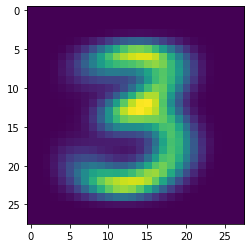

In [16]:
import matplotlib.pyplot as plt
plt.imshow(X_mean[3])

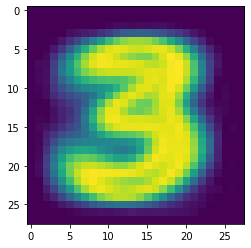

In [17]:
plt.imshow(X_std[3])

###### time performance comparison of apply_gaussian_naive_bayes with apply_gaussian_naive_bayes<font color="magenta">_fast</font>

In [9]:
import time

start = time.time()
pred_cls = apply_gaussian_naive_bayes(len(classes), dim_x, dim_y, prior, X_mean, X_std, x_test[0])
end = time.time()
print(end - start)

start = time.time()
pred_cls_fast = apply_gaussian_naive_bayes_fast(len(classes), dim_x, dim_y, prior, X_mean, X_std, x_test[0])
end = time.time()
print(end - start)

print(pred_cls)
print(pred_cls_fast)

#output
#6.216400146484375
#6.311165809631348
#7
#7

C:\Users\jeete\.conda\envs\Python37Env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\jeete\.conda\envs\Python37Env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


6.773550033569336
6.2529566287994385
7
7


#### Prediction

In [10]:
#iterate over test dataset and count the number of correct and incorrect predictions
count_correct, count_incorrect = 0, 0
#since each prediction is taking ~6 seconds, we can predict 10 digits per minute.
#allowing the classification to run for 10 minutes, we will have 100 predictions.
#so, setting the range as 0..100
for i in range(100): #len(x_test)):
    #actual class
    actual_cls = y_test[i]
    #predicted class
    # input provided as row[:-1].to_list(), means, all columns except last, converted to a list
    pred_cls = apply_gaussian_naive_bayes(len(classes), dim_x, dim_y, prior, X_mean, X_std, x_test[i])
    if classes[pred_cls] == actual_cls:
        count_correct += 1
    else:
        count_incorrect += 1
    print('(predicted, actual):', pred_cls, actual_cls)
print('Correct: ', count_correct, 'Incorrect: ', count_incorrect)
print('Percentage of correct predictions: ', (count_correct * 100)/(count_correct + count_incorrect))

(predicted, actual): 7 7
(predicted, actual): 2 2
(predicted, actual): 1 1
(predicted, actual): 0 0
(predicted, actual): 9 4
(predicted, actual): 1 1
(predicted, actual): 8 4
(predicted, actual): 9 9
(predicted, actual): 4 5
(predicted, actual): 9 9
(predicted, actual): 0 0
(predicted, actual): 6 6
(predicted, actual): 9 9
(predicted, actual): 0 0
(predicted, actual): 1 1
(predicted, actual): 0 5
(predicted, actual): 9 9
(predicted, actual): 7 7
(predicted, actual): 2 3
(predicted, actual): 9 4
(predicted, actual): 9 9
(predicted, actual): 6 6
(predicted, actual): 6 6
(predicted, actual): 8 5
(predicted, actual): 9 4
(predicted, actual): 0 0
(predicted, actual): 9 7
(predicted, actual): 9 4
(predicted, actual): 0 0
(predicted, actual): 1 1
(predicted, actual): 9 3
(predicted, actual): 1 1
(predicted, actual): 3 3
(predicted, actual): 0 4
(predicted, actual): 7 7
(predicted, actual): 0 2
(predicted, actual): 7 7
(predicted, actual): 1 1
(predicted, actual): 8 2
(predicted, actual): 1 1
